In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import os
import sys
import numpy as np
import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt
#from Heatmap_plot import Heatmap
from Training import GetDatasets
from Nets_original  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Simulation import buffer_simulation, save_obj, load_obj

tf.random.set_seed(1234)
np.random.seed(1234)

# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Get Dataset

In [3]:
#train_batch_size = test_batch_size = 32

train_set,valid_set,test_set = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, train_batch_size, test_batch_size)

NameError: name 'train_batch_size' is not defined

In [6]:
ZFNet     = GetNeuralNetworkModel('ZFNet',(224,224,3),8, quantization = False, aging_active=False)
loss      = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
ZFNet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Get Model

In [5]:
import tensorflow_datasets as tfds
tfds.load('colorectal_histology')

{'train': <PrefetchDataset shapes: {filename: (), image: (150, 150, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>}

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Training

In [7]:
(OrigLoss,OrigAcc) = ZFNet.evaluate(test_set)

24/24 [==============================] - 11s 438ms/step - loss: 2.1588 - accuracy: 0.1147


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Load/Save Weigths

In [7]:
# Early Stopping
# --------------
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
ZFNet.fit(x=trainSet,epochs=100,
            steps_per_epoch  =int(np.ceil(trainSize / trainBatchSize)),
            validation_data  =validSet,
            validation_steps =int(np.ceil(validSize/ trainBatchSize)), 
            callbacks=[earlyStop])

NameError: name 'trainSet' is not defined

In [8]:
cwd = os.getcwd()
wgtDir = os.path.join(cwd, 'Data')
wgtDir = os.path.join(wgtDir, 'Trained Weights')
wgtDir = os.path.join(wgtDir, 'ZFNet')
wgtDir = os.path.join(wgtDir, 'Colorectal Dataset')
wgtDir = os.path.join(wgtDir,'Weights')
ZFNet.load_weights(wgtDir)

# ZFNet.summary()

# 2) Stats

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  e) Activation Stats

In [15]:
ActivationStats(ZFNet,test_set,11,4,24)

mean value (MMU): 0.019087149
mean value (Buffer): 0.13289617
maximum (MMU): 6.6837068
minimum (MMU): -7.3264446
maximum (Buffer): 9.726532
minimum (Buffer): -2.4119244
saturation ratio (MMU): 0.0
saturation ratio (Buffer): 0.0


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  f) Write/Read Stats

In [3]:
Indices = [0,3,7,11,15,19,23,27,31,34,37,40]
Data    = GetReadAndWrites(ZFNet,Indices,279936,150,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(ZFNet,Indices,1024*1024,150,CNN_gating=True)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
CNN_gating_Acceses = pd.DataFrame(stats).reset_index(drop=False)
save_obj(Baseline_Acceses,'Data/Acceses/ZFNet/Baseline_v2')
save_obj(CNN_gating_Acceses,'Data/Acceses/ZFNet/CNN_gating_Fix_v2')

procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150
procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150


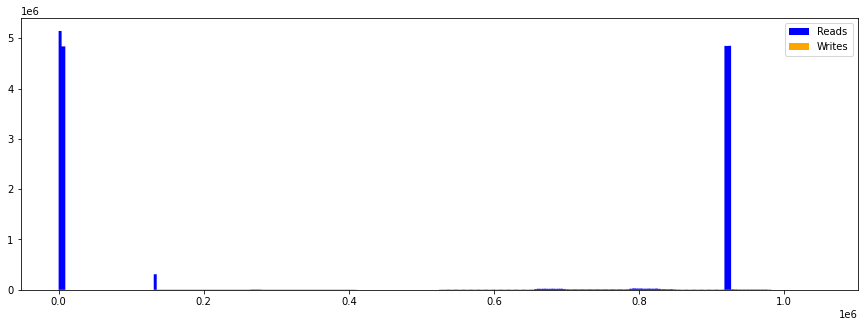

In [4]:
plt.figure(figsize=(15, 5))
plt.stackplot(CNN_gating_Acceses.to_dict()['index'].values(),
              CNN_gating_Acceses.to_dict()['Lecturas'].values(),
              CNN_gating_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

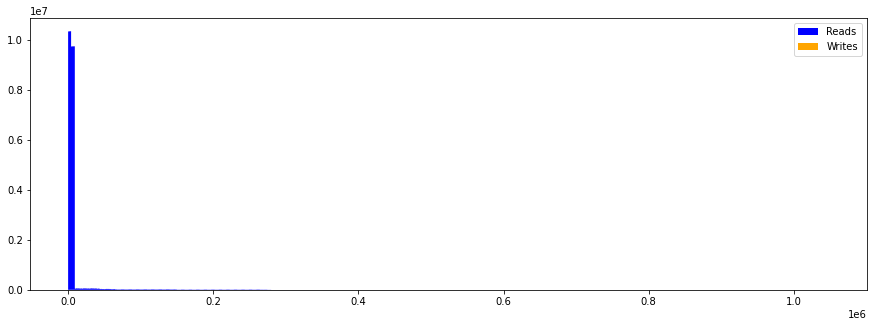

In [5]:
plt.figure(figsize=(15, 5))
plt.stackplot(Baseline_Acceses.to_dict()['index'].values(),
              Baseline_Acceses.to_dict()['Lecturas'].values(),
              Baseline_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

# 3) Quantization 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [14]:
CheckAccuracyAndLoss('ZFNet', testSet, wgtDir, aFracSize = 16, aIntSize = 16, wFracSize = 16, wIntSize = 16, 
                    inputShape = (224,224,3), outputShape = 8, batchSize = testBatchSize);

NameError: name 'testSet' is not defined

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Number of bits analysis

In [5]:
df = QuantizationEffect('ZFNet',testSet,wgtDir,(224,224,3),8,testBatchSize)
save_obj(df,'Data/Quantization/ZFNet/Colorectal Dataset/Quantization')

Activation fraction part
0  bits results:  acc:  0.11733333021402359 loss:  nan
1  bits results:  acc:  0.11733333021402359 loss:  nan
2  bits results:  acc:  0.41200000047683716 loss:  nan
3  bits results:  acc:  0.7173333168029785 loss:  2.0875744819641113
4  bits results:  acc:  0.8199999928474426 loss:  0.9084042906761169
5  bits results:  acc:  0.8253333568572998 loss:  0.7362842559814453
6  bits results:  acc:  0.8333333134651184 loss:  0.601003885269165
7  bits results:  acc:  0.8320000171661377 loss:  0.5906406044960022
8  bits results:  acc:  0.8333333134651184 loss:  0.5493967533111572
9  bits results:  acc:  0.8320000171661377 loss:  0.5404466390609741
10  bits results:  acc:  0.8333333134651184 loss:  0.5150176286697388
11  bits results:  acc:  0.8333333134651184 loss:  0.49447330832481384
12  bits results:  acc:  0.8333333134651184 loss:  0.48571646213531494
13  bits results:  acc:  0.8333333134651184 loss:  0.4851873517036438
14  bits results:  acc:  0.8333333134651184 lo

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Used Config

In [13]:
CheckAccuracyAndLoss('ZFNet', testSet, wgtDir, aFracSize = 11, aIntSize = 4, wFracSize = 15, wIntSize = 0, 
                    inputShape = (224,224,3), outputShape = 8, batchSize = testBatchSize);

NameError: name 'testSet' is not defined

# 3) Buffer Simulation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Baseline

In [15]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

QZFNet  = GetNeuralNetworkModel('ZFNet',(224,224,3),8, quantization = True, aging_active=False, word_size = 16, frac_size = 11)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
QZFNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QZFNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QZFNet, frac_bits = 15, int_bits = 0)


LI = [0,3,7 ,11,15,19,23,27,31,34,37,40]
AI = [2,6,10,14,18,22,26,30,32,36,39,43]
buffer_simulation(QZFNet,testSet, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/ZFNet/Colorectal Dataset/Baseline/', buffer_size = 2*1024*1024,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 131072, 262144, 393216, 524288, 655360, 786432, 917504, 1048576]
Simulation Started, time: 11:35:46 cycles:  0 offset:  0


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; CNN-Gated

In [4]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

QZFNet  = GetNeuralNetworkModel('ZFNet',(224,224,3),8, quantization = True, aging=False, wordSize = 16, fracSize = 11)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
QZFNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QZFNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QZFNet, fracBits = 15, intBits = 0)


LI = [0,3,7 ,11,15,19,23,27,31,34,37,40]
AI = [2,6,10,14,18,22,26,30,32,36,39,43]
buffer_simulation(QZFNet,testSet, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/ZFNet/Colorectal Dataset/CNN-Gated/Full Buffer/', buffer_size = 2*1024*1024,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 131072, 262144, 393216, 524288, 655360, 786432, 917504, 1048576]
Simulation Started, time: 19:09:35 cycles:  0 offset:  0
procesed images: 0  time: 19:11:14 cycles:  2099986 offset:  131072
procesed images: 1  time: 19:11:29 cycles:  4199972 offset:  917504
procesed images: 2  time: 19:13:07 cycles:  6299958 offset:  1048576
procesed images: 3  time: 19:13:22 cycles:  8399944 offset:  786432
procesed images: 4  time: 19:15:02 cycles:  10499930 offset:  917504
procesed images: 5  time: 19:15:17 cycles:  12599916 offset:  655360
procesed images: 6  time: 19:16:55 cycles:  14699902 offset:  786432
procesed images: 7  time: 19:17:10 cycles:  16799888 offset:  524288
procesed images: 8  time: 19:18:48 cycles:  18899874 offset:  655360
procesed images: 9  time: 19:19:03 cycles:  20999860 offset:  393216
procesed images: 10  time: 19:20:42 cycles:  23099846 offset:  524288
procesed images: 11  time: 19:20:57 cycles:  25199832 offset:  262144
procesed images: 12  time: 19

procesed images: 114  time: 21:25:31 cycles:  241498390 offset:  1048576
procesed images: 115  time: 21:25:48 cycles:  243598376 offset:  786432
procesed images: 116  time: 21:28:17 cycles:  245698362 offset:  917504
procesed images: 117  time: 21:28:35 cycles:  247798348 offset:  655360
procesed images: 118  time: 21:31:00 cycles:  249898334 offset:  786432
procesed images: 119  time: 21:31:19 cycles:  251998320 offset:  524288
procesed images: 120  time: 21:33:40 cycles:  254098306 offset:  655360
procesed images: 121  time: 21:33:57 cycles:  256198292 offset:  393216
procesed images: 122  time: 21:36:16 cycles:  258298278 offset:  524288
procesed images: 123  time: 21:36:33 cycles:  260398264 offset:  262144
procesed images: 124  time: 21:38:57 cycles:  262498250 offset:  393216
procesed images: 125  time: 21:39:15 cycles:  264598236 offset:  131072
procesed images: 126  time: 21:41:43 cycles:  266698222 offset:  262144
procesed images: 127  time: 21:42:02 cycles:  268798208 offset:

({'Number of Addresses': 1048576,
  'Data': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
  'HighCyclesCount': array([12929009,   623115,   460832, ..., 23278986, 27924907, 28886513],
        dtype=uint32),
  'OffCyclesCount': array([252700875, 252700875, 252700875, ..., 254233025, 254233025,
         254233025], dtype=uint32),
  'LowCyclesCount': array([49368016, 61673910, 61836193, ..., 37485889, 32839968, 31878362],
        dtype=uint32),
  'Flips': array([78, 63, 73, ..., 12, 14, 19], dtype=uint32),
  'offset': 655360},
 314997900)

In [3]:
trainBatchSize = testBatchSize = 1
_,_,testSet = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

QZFNet  = GetNeuralNetworkModel('ZFNet',(224,224,3),8, quantization = True, aging=False, wordSize = 16, fracSize = 11)
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
QZFNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QZFNet.load_weights(wgtDir).expect_partial()
WeightQuantization(model = QZFNet, fracBits = 15, intBits = 0)


LI = [0,3,7 ,11,15,19,23,27,31,34,37,40]
AI = [2,6,10,14,18,22,26,30,32,36,39,43]
buffer_simulation(QZFNet,testSet, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = True, write_mode ='default',
                 results_dir = 'Data/Stats/ZFNet/Colorectal Dataset/CNN-Gated/Adjusted Buffer/', buffer_size = 2*1140576,
                 layer_indexes = LI , activation_indixes = AI)

buffer sections:  [0, 142572, 285144, 427716, 570288, 712860, 855432, 998004, 1140576]
Simulation Started, time: 22:37:06 cycles:  0 offset:  0
procesed images: 0  time: 22:38:48 cycles:  2099986 offset:  1140576
procesed images: 1  time: 22:40:44 cycles:  4199972 offset:  855432
procesed images: 2  time: 22:42:20 cycles:  6299958 offset:  855432
procesed images: 3  time: 22:44:16 cycles:  8399944 offset:  570288
procesed images: 4  time: 22:45:52 cycles:  10499930 offset:  570288
procesed images: 5  time: 22:47:48 cycles:  12599916 offset:  285144
procesed images: 6  time: 22:49:23 cycles:  14699902 offset:  285144
procesed images: 7  time: 22:51:19 cycles:  16799888 offset:  1140576
procesed images: 8  time: 22:52:54 cycles:  18899874 offset:  1140576
procesed images: 9  time: 22:54:50 cycles:  20999860 offset:  855432
procesed images: 10  time: 22:56:26 cycles:  23099846 offset:  855432
procesed images: 11  time: 22:58:21 cycles:  25199832 offset:  570288
procesed images: 12  time: 

procesed images: 114  time: 01:59:30 cycles:  241498390 offset:  855432
procesed images: 115  time: 02:01:26 cycles:  243598376 offset:  570288
procesed images: 116  time: 02:03:02 cycles:  245698362 offset:  570288
procesed images: 117  time: 02:04:58 cycles:  247798348 offset:  285144
procesed images: 118  time: 02:06:34 cycles:  249898334 offset:  285144
procesed images: 119  time: 02:08:30 cycles:  251998320 offset:  1140576
procesed images: 120  time: 02:10:05 cycles:  254098306 offset:  1140576
procesed images: 121  time: 02:12:01 cycles:  256198292 offset:  855432
procesed images: 122  time: 02:13:37 cycles:  258298278 offset:  855432
procesed images: 123  time: 02:15:32 cycles:  260398264 offset:  570288
procesed images: 124  time: 02:17:08 cycles:  262498250 offset:  570288
procesed images: 125  time: 02:19:04 cycles:  264598236 offset:  285144
procesed images: 126  time: 02:20:40 cycles:  266698222 offset:  285144
procesed images: 127  time: 02:22:35 cycles:  268798208 offset

({'Number of Addresses': 1140576,
  'Data': array([2, 2, 2, ..., 2, 2, 2], dtype=int8),
  'HighCyclesCount': array([11377638,  2514982,  2924279, ..., 20214040, 21326345, 21903719],
        dtype=uint32),
  'OffCyclesCount': array([237251134, 237251134, 237251134, ..., 239865902, 239865902,
         239865902], dtype=uint32),
  'LowCyclesCount': array([66369128, 75231784, 74822487, ..., 54917958, 53805653, 53228279],
        dtype=uint32),
  'Flips': array([ 99, 101,  96, ...,  45,  51,  45], dtype=uint32),
  'offset': 285144},
 314997900)

# 4) Error Injection

In [3]:
trainBatchSize = testBatchSize = 64
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(224,224), 8, trainBatchSize, testBatchSize)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Measuring effect of faults in address by number

In [8]:
from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools

Start_from_zero = True

if Start_from_zero:
    Accs     = {0.00001:[],0.00005:[],0.0001:[]}
    Loss     = {0.00001:[],0.00005:[],0.0001:[]}
else:
    Accs     = load_obj('Data/Errors/ZFNet/Uniform distribution/Accs')
    Loss     = load_obj('Data/Errors/ZFNet/Colorectal Dataset/Loss')

    
network_size   = 1140576*16
num_of_samples = 200
for Enumber in Accs:
    n_bits_fails = np.ceil(Enumber*network_size).astype(int)
    errors       = np.random.randint(0,2,n_bits_fails)
    buffer       = np.array(['x']*(network_size-n_bits_fails))
    buffer_with_errors = np.concatenate([buffer,errors])
    for index in range(0,num_of_samples):
        np.random.shuffle(buffer_with_errors)
        address_with_errors = np.reshape(buffer_with_errors,(-1,16))
        address_with_errors = ["".join(i) for i in address_with_errors]
        error_mask = [y for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        locs       = [x for x,y in enumerate(address_with_errors) if y.count('x') < 16]
        loss,acc   = CheckAccuracyAndLoss('ZFNet', test_dataset, wgtDir, outputShape=8, inputShape = (224,224,3),
                                            aFracSize = 11, aIntSize = 4, wFracSize = 15, wIntSize = 0,
                                            batchSize=testBatchSize, verbose = 0, aging = True,
                                            faultyAddresses = locs, maskedFaults = error_mask)
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    save_obj(Accs,'Data/Errors/ZFNet/Colorectal Dataset/Uniform distribution/Accs')
    save_obj(Loss,'Data/Errors/ZFNet/Colorectal Dataset/Uniform distribution/Loss')

1e-05 completada:  14:53:21
5e-05 completada:  15:32:10
0.0001 completada:  16:16:55


In [9]:
from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools

Start_from_zero = True

if Start_from_zero:
    Accs     = {0.00001:[],0.00005:[],0.0001:[]}
    Loss     = {0.00001:[],0.00005:[],0.0001:[]}
else:
    Accs     = load_obj('Data/Errors/ZFNet/Colorectal Dataset/Uniform distribution/weights Accs')
    Loss     = load_obj('Data/Errors/ZFNet/Colorectal Dataset/Uniform distribution/weights Loss')

    
network_size   = 1327488*16
num_of_samples = 200
for Enumber in Accs:
    n_bits_fails = np.ceil(Enumber*1140576).astype(int)
    errors       = np.random.randint(0,2,n_bits_fails)
    buffer       = np.array(['x']*(network_size-n_bits_fails))
    buffer       = np.concatenate([buffer,errors])
    for index in range(0,num_of_samples):
        np.random.shuffle(buffer)
        address_with_errors = np.reshape(buffer,(-1,16))
        address_with_errors = enumerate(["".join(i) for i in address_with_errors])
        error_mask = [y for x,y in address_with_errors if y.count('x') < 16]
        locs       = [x for x,y in address_with_errors if y.count('x') < 16]
        del address_with_errors
        loss,acc   = CheckAccuracyAndLoss('ZFNet', test_dataset, wgtDir, outputShape=8, inputShape = (224,224,3),
                                            aFracSize = 11, aIntSize = 4, wFracSize = 15, wIntSize = 0,
                                            batchSize=testBatchSize, verbose = 0, aging = False, WeightsFaults = True,
                                            faultyAddresses = locs, maskedFaults = error_mask)
        print(index,' completados: ', datetime.now().strftime("%H:%M:%S"))
        Accs[Enumber].append(acc)
        Loss[Enumber].append(loss)
    print(str(Enumber)+' completada: ', datetime.now().strftime("%H:%M:%S"))
    save_obj(Accs,'Data/Errors/ZFNet/Colorectal Dataset/Uniform distribution/weights Accs')
    save_obj(Loss,'Data/Errors/ZFNet/Colorectal Dataset/Uniform distribution/weights Loss')

0  completados:  16:17:08
1  completados:  16:17:18
2  completados:  16:17:29
3  completados:  16:17:40
4  completados:  16:17:50
5  completados:  16:18:01
6  completados:  16:18:10
7  completados:  16:18:21
8  completados:  16:18:31
9  completados:  16:18:41
10  completados:  16:18:50
11  completados:  16:18:59
12  completados:  16:19:08
13  completados:  16:19:17
14  completados:  16:19:26
15  completados:  16:19:36
16  completados:  16:19:45
17  completados:  16:19:54
18  completados:  16:20:02
19  completados:  16:20:12
20  completados:  16:20:22
21  completados:  16:20:31
22  completados:  16:20:40
23  completados:  16:20:49
24  completados:  16:20:58
25  completados:  16:21:07
26  completados:  16:21:16
27  completados:  16:21:25
28  completados:  16:21:34
29  completados:  16:21:43
30  completados:  16:21:52
31  completados:  16:22:01
32  completados:  16:22:10
33  completados:  16:22:19
34  completados:  16:22:28
35  completados:  16:22:37
36  completados:  16:22:46
37  complet

100  completados:  17:01:36
101  completados:  17:01:45
102  completados:  17:01:54
103  completados:  17:02:03
104  completados:  17:02:12
105  completados:  17:02:21
106  completados:  17:02:30
107  completados:  17:02:39
108  completados:  17:02:48
109  completados:  17:02:57
110  completados:  17:03:07
111  completados:  17:03:16
112  completados:  17:03:25
113  completados:  17:03:34
114  completados:  17:03:44
115  completados:  17:03:53
116  completados:  17:04:03
117  completados:  17:04:13
118  completados:  17:04:22
119  completados:  17:04:31
120  completados:  17:04:41
121  completados:  17:04:51
122  completados:  17:05:01
123  completados:  17:05:11
124  completados:  17:05:21
125  completados:  17:05:31
126  completados:  17:05:41
127  completados:  17:05:51
128  completados:  17:06:01
129  completados:  17:06:11
130  completados:  17:06:21
131  completados:  17:06:31
132  completados:  17:06:41
133  completados:  17:06:51
134  completados:  17:07:01
135  completados:  1

196  completados:  17:51:31
197  completados:  17:51:41
198  completados:  17:51:51
199  completados:  17:52:01
0.0001 completada:  17:52:01
